In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Paths to the files in Google Drive
train_data_path = '/content/drive/My Drive/Train_data.csv'
test_data_path = '/content/drive/My Drive/Test_data.csv'
val_data_path = '/content/drive/My Drive/Val_data.csv'

# Load the CSV files
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
val_data = pd.read_csv(val_data_path)

In [ ]:
train_metadata_path = '/content/drive/My Drive/Train_metadata.npy'
test_metadata_path = '/content/drive/My Drive/Test_metadata.npy'
val_metadata_path = '/content/drive/My Drive/Val_metadata.npy'

train_metadata = np.load(train_metadata_path)
test_metadata = np.load(test_metadata_path)
val_metadata = np.load(val_metadata_path)

In [ ]:
train_image_features_path = '/content/drive/My Drive/Train_image_features.npy'
test_image_features_path = '/content/drive/My Drive/Test_image_features.npy'
val_image_features_path = '/content/drive/My Drive/Val_image_features.npy'

train_image_features_array  = np.load(train_image_features_path)
test_image_features_array  = np.load(test_image_features_path)
val_image_features_array = np.load(val_image_features_path)

In [ ]:
# Extract target labels
y_train = train_data['Recurrence'].map({'Yes': 1, 'No': 0}).values
y_val = val_data['Recurrence'].map({'Yes': 1, 'No': 0}).values
y_test = test_data['Recurrence'].map({'Yes': 1, 'No': 0}).values

# Verify the unique values to confirm conversion
print("Unique values in y_train:", set(y_train))
print("Unique values in y_val:", set(y_val))
print("Unique values in y_test:", set(y_test))



Unique values in y_train: {0, 1}
Unique values in y_val: {0, 1}
Unique values in y_test: {0, 1}


In [ ]:
print(f"Train Metadata Shape: {train_metadata.shape}")
print(f"Train Image Features Shape: {train_image_features_array.shape}")
print(f"Train Labels Shape: {y_train.shape}")


Train Metadata Shape: (2834, 79)
Train Image Features Shape: (2834, 768)
Train Labels Shape: (2834,)


Epoch 1/20, Train Loss: 0.2990, Train Accuracy: 0.8740, Validation Loss: 0.0526, Validation Accuracy: 0.9915
Epoch 2/20, Train Loss: 0.0200, Train Accuracy: 0.9968, Validation Loss: 0.0084, Validation Accuracy: 0.9968
Epoch 3/20, Train Loss: 0.0075, Train Accuracy: 0.9979, Validation Loss: 0.0052, Validation Accuracy: 0.9989
Epoch 4/20, Train Loss: 0.0027, Train Accuracy: 0.9993, Validation Loss: 0.0037, Validation Accuracy: 0.9989
Epoch 5/20, Train Loss: 0.0035, Train Accuracy: 0.9989, Validation Loss: 0.0026, Validation Accuracy: 0.9989
Epoch 6/20, Train Loss: 0.0012, Train Accuracy: 0.9996, Validation Loss: 0.0024, Validation Accuracy: 1.0000
Epoch 7/20, Train Loss: 0.0009, Train Accuracy: 1.0000, Validation Loss: 0.0017, Validation Accuracy: 0.9989
Epoch 8/20, Train Loss: 0.0012, Train Accuracy: 1.0000, Validation Loss: 0.0014, Validation Accuracy: 1.0000
Epoch 9/20, Train Loss: 0.0005, Train Accuracy: 1.0000, Validation Loss: 0.0014, Validation Accuracy: 1.0000
Epoch 10/20, Train 

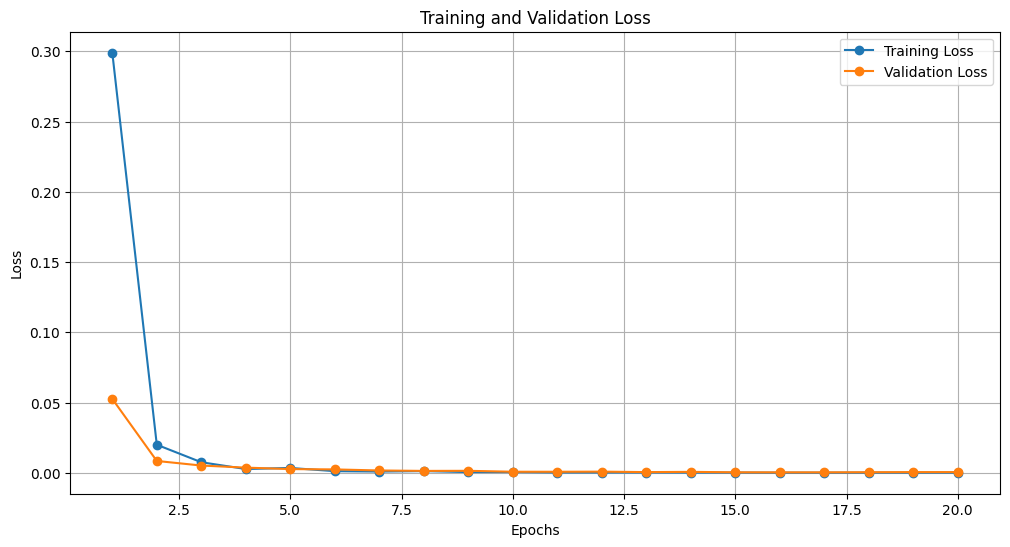

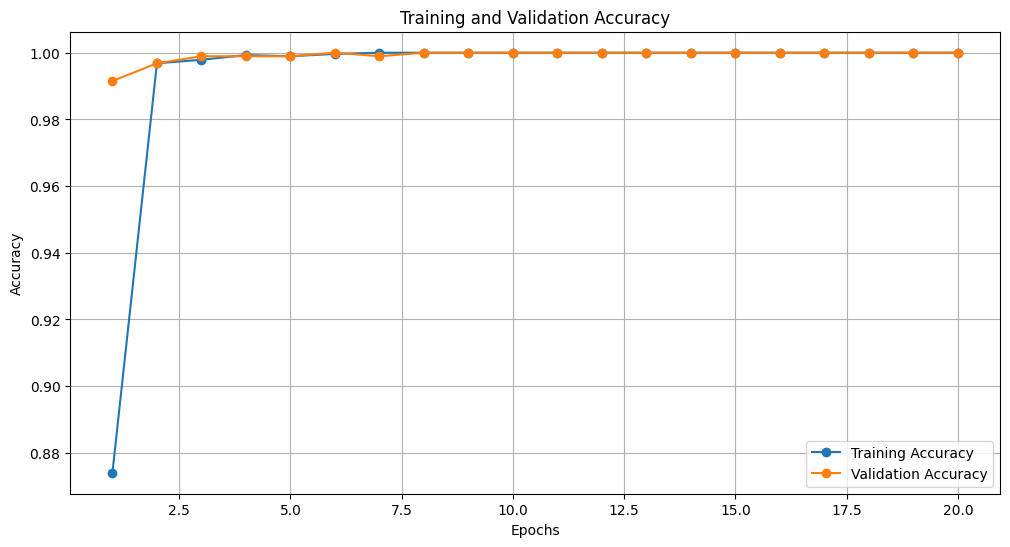

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the PyTorch model
class FusionModel(nn.Module):
    def __init__(self, metadata_dim, image_dim):
        super(FusionModel, self).__init__()
        # Metadata branch
        self.metadata_branch = nn.Sequential(
            nn.Linear(metadata_dim, 64),  # Equivalent to Dense(64)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),  # Equivalent to Dense(32)
            nn.ReLU()
        )
        # Image branch
        self.image_branch = nn.Sequential(
            nn.Linear(image_dim, 128),  # Equivalent to Dense(128)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),  # Equivalent to Dense(64)
            nn.ReLU()
        )
        # Fusion layer
        self.fusion_layer = nn.Linear(32 + 64, 1)  # Concatenate outputs and map to single output
        self.output = nn.Sigmoid()  # Equivalent to Dense(1, activation='sigmoid')

    def forward(self, metadata_input, image_input):
        # Process metadata and image inputs through their branches
        metadata_features = self.metadata_branch(metadata_input)
        image_features = self.image_branch(image_input)
        # Concatenate features
        fusion_features = torch.cat((metadata_features, image_features), dim=1)
        # Final output
        out = self.output(self.fusion_layer(fusion_features))
        return out

# Model parameters
metadata_dim = 79  # Number of metadata features
image_dim = 768  # Dimension of image features
model = FusionModel(metadata_dim, image_dim)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
train_metadata_tensor = torch.tensor(train_metadata, dtype=torch.float32)
train_image_tensor = torch.tensor(train_image_features_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

val_metadata_tensor = torch.tensor(val_metadata, dtype=torch.float32)
val_image_tensor = torch.tensor(val_image_features_array, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for training
train_dataset = TensorDataset(train_metadata_tensor, train_image_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_metadata_tensor, val_image_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

import matplotlib.pyplot as plt

# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for metadata_batch, image_batch, target_batch in train_loader:
        # Forward pass
        output = model(metadata_batch, image_batch)
        loss = criterion(output, target_batch)
        train_loss += loss.item()

        # Calculate accuracy
        preds = (output >= 0.5).float()  # Threshold at 0.5
        correct_train += (preds == target_batch).sum().item()
        total_train += target_batch.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for metadata_batch, image_batch, target_batch in val_loader:
            output = model(metadata_batch, image_batch)
            loss = criterion(output, target_batch)
            val_loss += loss.item()

            # Calculate accuracy
            preds = (output >= 0.5).float()  # Threshold at 0.5
            correct_val += (preds == target_batch).sum().item()
            total_val += target_batch.size(0)

    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Print loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

# Final metrics
print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Plot Loss Curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch

# Define a custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, metadata, image_features, labels):
        self.metadata = torch.tensor(metadata, dtype=torch.float32)
        self.image_features = torch.tensor(image_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.metadata[idx], self.image_features[idx], self.labels[idx]

# Create the test dataset
test_dataset = CustomDataset(test_metadata, test_image_features_array, y_test)

# Define the DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Test Loss: 0.0008
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1-Score: 1.0000


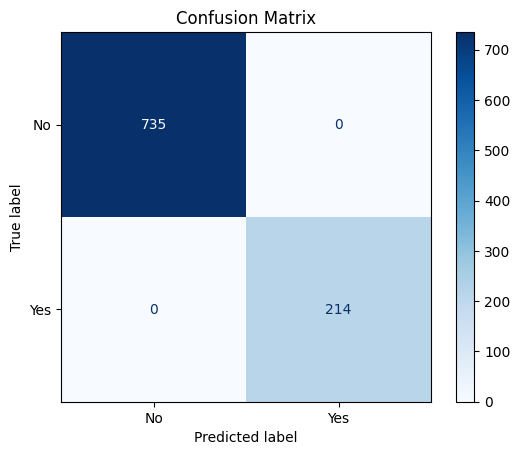

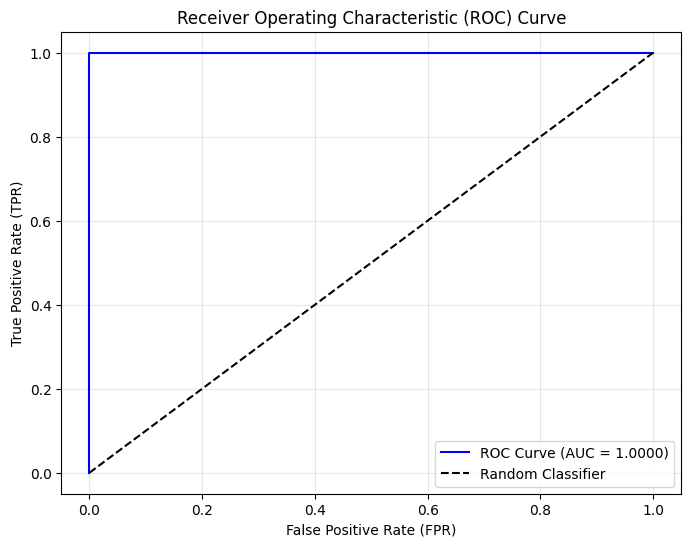

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Initialize lists to store true labels, predictions, and raw outputs
true_labels = []
predicted_labels = []
raw_outputs = []

model.eval()  # Set the model to evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient computation
    for metadata_batch, image_batch, target_batch in test_loader:
        # Forward pass
        output = model(metadata_batch, image_batch).squeeze(1)  # Match target shape
        loss = criterion(output, target_batch)  # Binary Cross-Entropy Loss
        test_loss += loss.item()

        # Threshold predictions at 0.5
        preds = (output >= 0.5).float()

        # Store raw outputs, predictions, and true labels
        raw_outputs.extend(output.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(target_batch.cpu().numpy())

# Calculate average loss
test_loss /= len(test_loader)

# Convert to NumPy arrays for metric calculations
true_labels = np.array(true_labels).flatten()
predicted_labels = np.array(predicted_labels).flatten()
raw_outputs = np.array(raw_outputs).flatten()

# Calculate metrics
test_accuracy = accuracy_score(true_labels, predicted_labels)
test_precision = precision_score(true_labels, predicted_labels)
test_recall = recall_score(true_labels, predicted_labels)
test_f1 = f1_score(true_labels, predicted_labels)

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])  # Replace with your class names
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calculate ROC-AUC
roc_auc = roc_auc_score(true_labels, raw_outputs)
fpr, tpr, thresholds = roc_curve(true_labels, raw_outputs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Define thresholds for risk categories
def get_risk_category(probability):
    if probability < 0.3:
        return "Low Risk", "Not Likely to Recur", "Follow-up in 1 - 3 Years"
    elif 0.3 <= probability < 0.7:
        return "Moderate Risk", "Likely to Recur", "Follow-up in 6 - 12 Months"
    else:
        return "High Risk", "Likely to Recur", "Follow-up in 3 - 6 Months"

# Define thresholds for malignancy likelihood
def get_malignancy_prediction(probability):
    if probability < 0.2:
        return "Low Likelihood of Malignancy", f"Malignancy Probability: {probability:.2f}"
    elif 0.2 <= probability < 0.5:
        return "Moderate Likelihood of Malignancy", f"Malignancy Probability: {probability:.2f}"
    else:
        return "High Likelihood of Malignancy", f"Malignancy Probability: {probability:.2f}"

# Generate recommendations and malignancy predictions
recommendations = []
for prob in raw_outputs:
    # Get recurrence predictions and recommendations
    risk_category, binary_prediction, recommendation = get_risk_category(prob)
    # Get malignancy predictions
    malignancy_category, malignancy_score = get_malignancy_prediction(prob)
    recommendations.append((risk_category, binary_prediction, recommendation, malignancy_category, malignancy_score))

# Display recommendations and malignancy predictions
for i, (prob, rec) in enumerate(zip(raw_outputs, recommendations)):
    risk_category, binary_prediction, recommendation, malignancy_category, malignancy_score = rec
    print(f"Sample {i+1}: Probability = {prob:.4f}, "
          f"Binary Prediction = {binary_prediction}, "
          f"Risk Category = {risk_category}, Recommendation = {recommendation}, "
          f"{malignancy_category}, {malignancy_score}")


Sample 1: Probability = 0.0002, Binary Prediction = Not Likely to Recur, Risk Category = Low Risk, Recommendation = Follow-up in 1 - 3 Years, Low Likelihood of Malignancy, Malignancy Probability: 0.00
Sample 2: Probability = 0.0003, Binary Prediction = Not Likely to Recur, Risk Category = Low Risk, Recommendation = Follow-up in 1 - 3 Years, Low Likelihood of Malignancy, Malignancy Probability: 0.00
Sample 3: Probability = 0.0001, Binary Prediction = Not Likely to Recur, Risk Category = Low Risk, Recommendation = Follow-up in 1 - 3 Years, Low Likelihood of Malignancy, Malignancy Probability: 0.00
Sample 4: Probability = 0.0001, Binary Prediction = Not Likely to Recur, Risk Category = Low Risk, Recommendation = Follow-up in 1 - 3 Years, Low Likelihood of Malignancy, Malignancy Probability: 0.00
Sample 5: Probability = 1.0000, Binary Prediction = Likely to Recur, Risk Category = High Risk, Recommendation = Follow-up in 3 - 6 Months, High Likelihood of Malignancy, Malignancy Probability: 1

In [ ]:
import pandas as pd

# Paths to the files in Google Drive
train_data_path = '/content/drive/My Drive/Train_data.csv'
test_data_path = '/content/drive/My Drive/Test_data.csv'
val_data_path = '/content/drive/My Drive/Val_data.csv'

# Load the CSV files
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
val_data = pd.read_csv(val_data_path)

# Combine the datasets
combined_data = pd.concat([train_data, test_data, val_data], axis=0, ignore_index=True)

# Check the combined data
print(f"Combined dataset contains {combined_data.shape[0]} rows and {combined_data.shape[1]} columns.")


Combined dataset contains 4727 rows and 83 columns.


In [ ]:
import pandas as pd
import numpy as np

# Simulated parameters
time_steps = 5  # Number of time steps (e.g., yearly observations)

# Initialize an empty list to store time-series data
time_series_data_new= []

# Group the combined dataset by Patient_ID
grouped_data = combined_data.groupby("Patient_ID")

# Iterate through each patient group
for patient_id, group in grouped_data:
    # Use the first row's size and morphology as the starting point
    base_size = group["Size_cm"].values[0]
    base_morphology = group["Morphology"].values[0] if "Morphology" in group.columns else "Unknown"

    # Simulate growth rate for size and possible morphology changes
    growth_rate = np.random.uniform(0.1, 0.5)  # Simulated growth rate

    for t in range(time_steps):
        # Calculate size at each time step
        size = base_size + growth_rate * t

        # Simulate morphology transitions
        if base_morphology == "Low Risk":
            morphology = "Low Risk" if np.random.rand() > 0.1 else "Moderate Risk"
        elif base_morphology == "Moderate Risk":
            morphology = "Moderate Risk" if np.random.rand() > 0.3 else "High Risk"
        else:
            morphology = "High Risk"

        # Append the time-series row
        time_series_data_new.append({
            "Patient_ID": patient_id,
            "Time_Step": t + 1,
            "Size_cm": size,
            "Morphology": morphology,
            "Recurrence": group["Recurrence"].values[0],  # Use the original recurrence value
        })

# Convert the time-series data to a DataFrame
time_series_df = pd.DataFrame(time_series_data_new)

# Display the resulting time-series dataset
print(f"Time-series dataset contains {time_series_df.shape[0]} rows and {time_series_df.shape[1]} columns.")
print(time_series_df.head())


Time-series dataset contains 515 rows and 5 columns.
   Patient_ID  Time_Step   Size_cm Morphology Recurrence
0       23002          1  0.042553  High Risk         No
1       23002          2  0.488848  High Risk         No
2       23002          3  0.935143  High Risk         No
3       23002          4  1.381437  High Risk         No
4       23002          5  1.827732  High Risk         No


In [ ]:
# Add Size_Class column to the time_series_df
def size_to_class(size):
    if size < 1:
        return "Small"
    elif size < 3:
        return "Medium"
    else:
        return "Large"

time_series_df["Size_Class"] = time_series_df["Size_cm"].apply(size_to_class)

# Verify the new column
print(time_series_df[["Size_cm", "Size_Class"]].head())


    Size_cm Size_Class
0  0.042553      Small
1  0.488848      Small
2  0.935143      Small
3  1.381437     Medium
4  1.827732     Medium


In [ ]:
# Save to a CSV file
time_series_df.to_csv('/content/drive/My Drive/Time_Series_Data.csv', index=False)
print("Time-series dataset saved to Google Drive as 'Time_Series_Data.csv'.")


Time-series dataset saved to Google Drive as 'Time_Series_Data.csv'.


In [ ]:
# Split data by Patient_ID
patient_ids = time_series_df["Patient_ID"].unique()
np.random.shuffle(patient_ids)

# Train: 70%, Validation: 15%, Test: 15%
train_size = int(0.7 * len(patient_ids))
val_size = int(0.15 * len(patient_ids))

train_ids = patient_ids[:train_size]
val_ids = patient_ids[train_size:train_size + val_size]
test_ids = patient_ids[train_size + val_size:]

# Split the dataset
train_df = time_series_df[time_series_df["Patient_ID"].isin(train_ids)]
val_df = time_series_df[time_series_df["Patient_ID"].isin(val_ids)]
test_df = time_series_df[time_series_df["Patient_ID"].isin(test_ids)]

# Display the splits
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 360, Validation size: 75, Test size: 80


In [ ]:
# Helper function to reshape time-series data
def prepare_lstm_data(df, feature_cols, label_col, time_steps):
    sequences = []
    labels = []
    grouped = df.groupby("Patient_ID")  # Group by Patient_ID

    for _, group in grouped:
        group = group.sort_values("Time_Step")  # Ensure temporal order
        for i in range(len(group) - time_steps + 1):
            seq = group.iloc[i:i + time_steps][feature_cols].values
            label = group.iloc[i + time_steps - 1][label_col]
            sequences.append(seq)
            labels.append(label)

    return np.array(sequences), np.array(labels)

# Define feature and label columns
feature_cols = ["Size_cm"]  # Add more features as needed
label_col = "Size_Class"  # Predict future size class

# Convert size classes to integers (e.g., Small=0, Medium=1, Large=2)
size_class_mapping = {"Small": 0, "Medium": 1, "Large": 2}
train_df["Size_Class"] = train_df["Size_Class"].map(size_class_mapping)
val_df["Size_Class"] = val_df["Size_Class"].map(size_class_mapping)
test_df["Size_Class"] = test_df["Size_Class"].map(size_class_mapping)

# Prepare the data
time_steps = 5
X_train, y_train = prepare_lstm_data(train_df, feature_cols, label_col, time_steps)
X_val, y_val = prepare_lstm_data(val_df, feature_cols, label_col, time_steps)
X_test, y_test = prepare_lstm_data(test_df, feature_cols, label_col, time_steps)

# Print shapes
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


Train shape: (72, 5, 1), (72,)
Validation shape: (15, 5, 1), (15,)
Test shape: (16, 5, 1), (16,)


<ipython-input-12-56996e9e7eaa>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Size_Class"] = train_df["Size_Class"].map(size_class_mapping)
<ipython-input-12-56996e9e7eaa>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["Size_Class"] = val_df["Size_Class"].map(size_class_mapping)
<ipython-input-12-56996e9e7eaa>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(time_steps, len(feature_cols)), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")  # 3 classes: Small, Medium, Large
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.1684 - loss: 1.1359 - val_accuracy: 0.8000 - val_loss: 1.0719
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4696 - loss: 1.0850 - val_accuracy: 0.8000 - val_loss: 0.9950
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6428 - loss: 1.0336 - val_accuracy: 0.8000 - val_loss: 0.9229
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6489 - loss: 0.9994 - val_accuracy: 0.8000 - val_loss: 0.8682
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6645 - loss: 0.9378 - val_accuracy: 0.8000 - val_loss: 0.8176
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6997 - loss: 0.8806 - val_accuracy: 0.8000 - val_loss: 0.7691
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6879 - loss: 0.8488 - val_accuracy: 0.8000 - val_loss: 0.7219
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6918 - loss: 0.8160 - val_accuracy: 0.8000 - val_loss: 0.6760

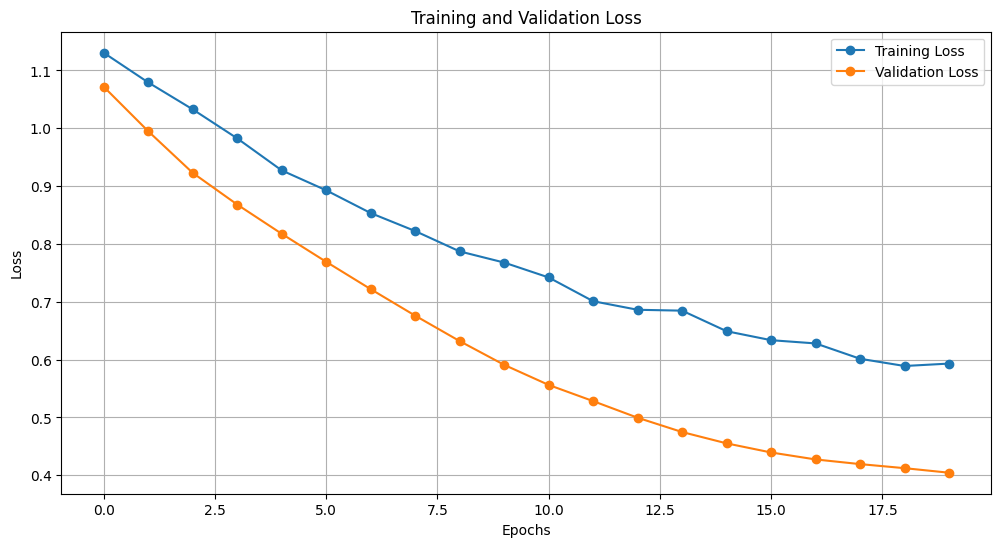

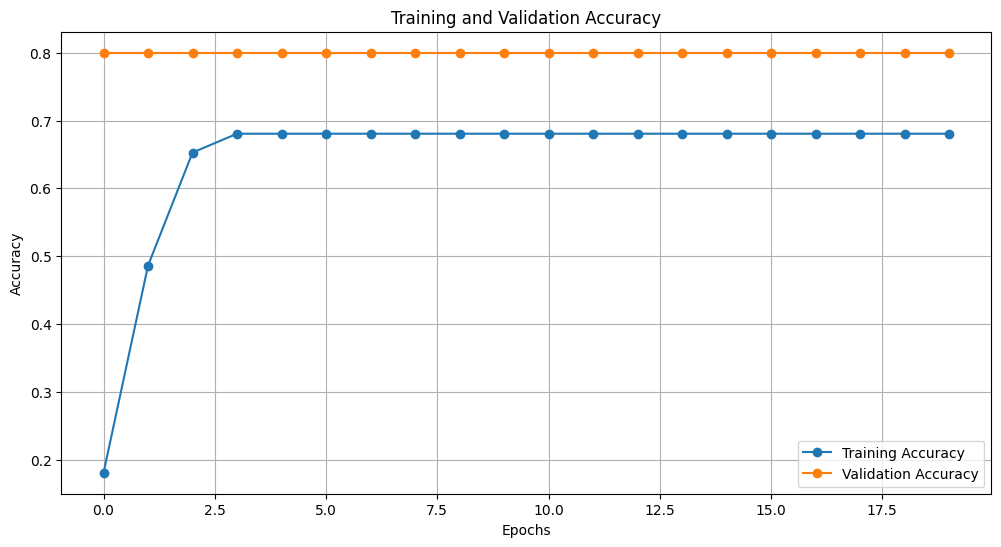

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss Curves
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss", marker="o")
plt.plot(history.history["val_loss"], label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy", marker="o")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [ ]:
print(f"Unique classes in y_test: {np.unique(y_test)}")
print(f"Unique classes in y_pred_classes: {np.unique(y_pred_classes)}")


Unique classes in y_test: [0 1]
Unique classes in y_pred_classes: [1]


In [ ]:
print(f"Shape of y_pred: {y_pred.shape}")


Shape of y_pred: (16, 3)


In [ ]:
# Predict class probabilities for the test data
y_pred = model.predict(X_test)  # Shape: (num_samples, num_classes)

# Get the predicted class for each sample
y_pred_classes = np.argmax(y_pred, axis=1)  # Shape: (num_samples,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
# Define class names for readability
class_names = ["Small", "Medium", "Large"]

# Convert true and predicted labels to class names
true_classes = [class_names[label] for label in y_test]  # Assuming y_test_multi is used
predicted_classes = [class_names[label] for label in y_pred_classes]

# Combine into a DataFrame for better readability
import pandas as pd
sample_predictions = pd.DataFrame({
    "True Class": true_classes,
    "Predicted Class": predicted_classes,
    "Small Probability": y_pred[:, 0],
    "Medium Probability": y_pred[:, 1],
    "Large Probability": y_pred[:, 2]
})

# Display first 10 rows
print("Sample Predictions:")
print(sample_predictions.head(10))


Sample Predictions:
  True Class Predicted Class  Small Probability  Medium Probability  \
0     Medium          Medium           0.106504            0.872477   
1     Medium          Medium           0.134570            0.835913   
2     Medium          Medium           0.124944            0.848587   
3     Medium          Medium           0.215103            0.723834   
4      Small          Medium           0.270598            0.638710   
5     Medium          Medium           0.187403            0.763707   
6     Medium          Medium           0.128065            0.844499   
7     Medium          Medium           0.243619            0.681081   
8     Medium          Medium           0.104495            0.880858   
9     Medium          Medium           0.109306            0.868877   

   Large Probability  
0           0.021019  
1           0.029517  
2           0.026469  
3           0.061063  
4           0.090692  
5           0.048890  
6           0.027436  
7           0.

Sample 1:
True Class: Medium
Predicted Class: Medium
Class Probabilities: Small=0.1045, Medium=0.8809, Large=0.0146



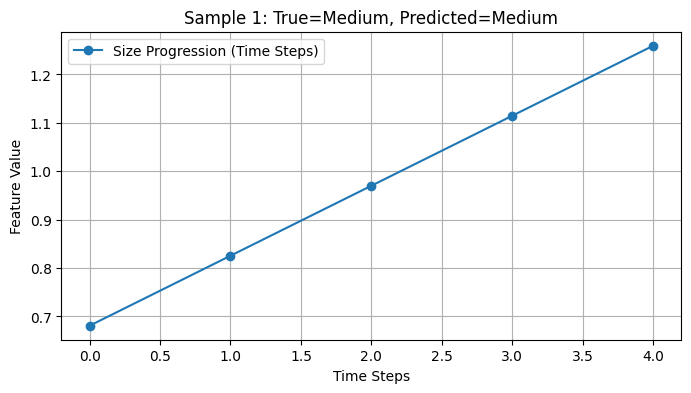

Sample 2:
True Class: Medium
Predicted Class: Medium
Class Probabilities: Small=0.1093, Medium=0.8689, Large=0.0218



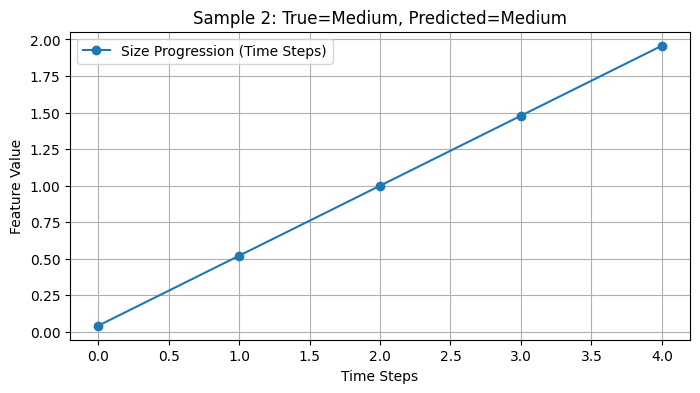

Sample 3:
True Class: Medium
Predicted Class: Medium
Class Probabilities: Small=0.2035, Medium=0.7408, Large=0.0558



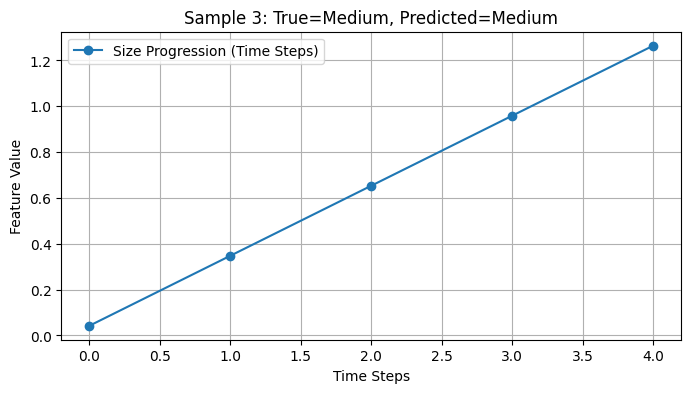

Sample 4:
True Class: Medium
Predicted Class: Medium
Class Probabilities: Small=0.1346, Medium=0.8359, Large=0.0295



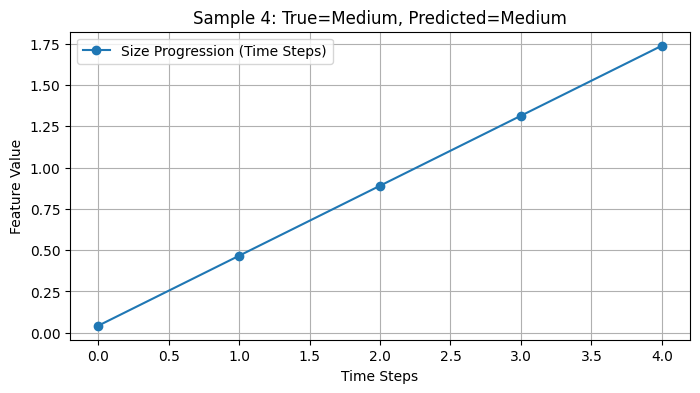

Sample 5:
True Class: Medium
Predicted Class: Medium
Class Probabilities: Small=0.2436, Medium=0.6811, Large=0.0753



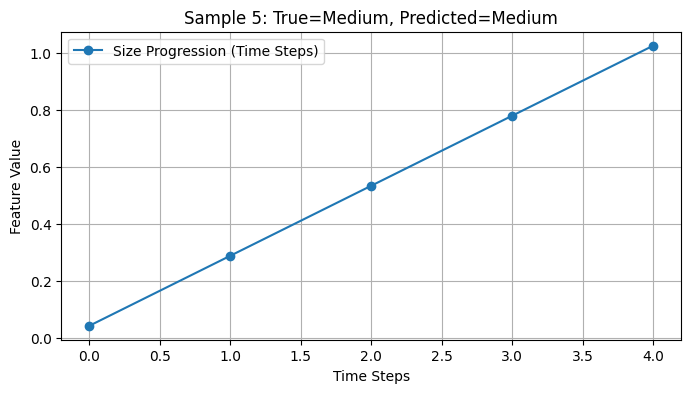

In [ ]:
import matplotlib.pyplot as plt

# Randomly select a few samples to visualize
num_samples_to_display = 5
random_indices = np.random.choice(len(X_test), num_samples_to_display, replace=False)

for i, idx in enumerate(random_indices):
    # Get sample data
    sample_features = X_test[idx]  # Shape: (time_steps, num_features)
    true_label = class_names[y_test[idx]]
    predicted_label = class_names[y_pred_classes[idx]]
    probabilities = y_pred[idx]

    # Display predictions
    print(f"Sample {i + 1}:")
    print(f"True Class: {true_label}")
    print(f"Predicted Class: {predicted_label}")
    print(f"Class Probabilities: Small={probabilities[0]:.4f}, Medium={probabilities[1]:.4f}, Large={probabilities[2]:.4f}")
    print()

    # Plot the feature sequence (e.g., size progression over time)
    plt.figure(figsize=(8, 4))
    plt.plot(sample_features[:, 0], marker="o", label="Size Progression (Time Steps)")
    plt.title(f"Sample {i + 1}: True={true_label}, Predicted={predicted_label}")
    plt.xlabel("Time Steps")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
import numpy as np

# Select two samples from the time-series dataset
# Replace `X_test` with your actual time-series input data
sample_1 = X_test[0:1]  # First sample (reshape to match LSTM input)
sample_2 = X_test[11:12]  # Second sample (reshape to match LSTM input)

# Make predictions for the selected samples
predicted_1 = model.predict(sample_1).squeeze()  # Predicted probabilities for Sample 1
predicted_2 = model.predict(sample_2).squeeze()  # Predicted probabilities for Sample 2

# Map predictions to morphology/size classes
size_classes = ["Small", "Medium", "Large"]  # Replace with your actual class labels
predicted_class_1 = size_classes[np.argmax(predicted_1)]
predicted_class_2 = size_classes[np.argmax(predicted_2)]

# Print results
print("Sample 1:")
print(f"Predicted Size Class: {predicted_class_1}")
print(f"Predicted Probabilities: {predicted_1}")

print("\nSample 2:")
print(f"Predicted Size Class: {predicted_class_2}")
print(f"Predicted Probabilities: {predicted_2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sample 1:
Predicted Size Class: Medium
Predicted Probabilities: [0.1065558  0.8724087  0.02103548]

Sample 2:
Predicted Size Class: Medium
Predicted Probabilities: [0.27825508 0.6262651  0.09547983]


In [ ]:
# Save the combined dataset to a CSV file in Google Drive
combined_data.to_csv('/content/drive/My Drive/Combined_Data.csv', index=False)
print("Combined dataset saved to Google Drive as 'Combined_Data.csv'.")


Combined dataset saved to Google Drive as 'Combined_Data.csv'.


In [ ]:
# Create Time_Step column if it doesn't exist
if 'Time_Step' not in combined_data.columns:
    combined_data['Time_Step'] = combined_data.groupby('Patient_ID').cumcount() + 1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load combined dataset
data_path = '/content/drive/My Drive/Combined_Data.csv'
combined_data = pd.read_csv(data_path)

# Verify columns
print("Columns in combined_data:", combined_data.columns)

# Remove unnecessary columns: File_Path and Split
if 'File_Path' in combined_data.columns or 'Split' in combined_data.columns:
    print("Removing columns: File_Path and Split")
    combined_data = combined_data.drop(columns=['File_Path', 'Split'], errors='ignore')

# Add Time_Step column if missing
if 'Time_Step' not in combined_data.columns:
    print("Adding a Time_Step column...")
    combined_data['Time_Step'] = combined_data.groupby('Patient_ID').cumcount() + 1

# Ensure binary columns are encoded
binary_columns = ["Recurrence"]  # Replace with actual binary column names
for col in binary_columns:
    combined_data[col] = combined_data[col].map({"Yes": 1, "No": 0})

# Add Morphology column if missing
if 'Morphology' not in combined_data.columns:
    print("Adding a default Morphology column...")
    combined_data['Morphology'] = np.random.choice(
        ['Tubular', 'Villous', 'Tubulovillous'], size=len(combined_data)
    )

# Ensure 'Size_Class' exists
if 'Size_Class' not in combined_data.columns:
    combined_data['Size_Class'] = pd.cut(
        combined_data['Size_cm'], bins=[0, 1, 3, float('inf')], labels=["Small", "Medium", "Large"]
    )

# Map Morphology to Risk Levels
if 'Morphology_Class' not in combined_data.columns:
    combined_data['Morphology_Class'] = combined_data['Morphology'].map({
        'Tubular': 'Low Risk',
        'Villous': 'High Risk',
        'Tubulovillous': 'Moderate Risk'
    })

# Encode Size_Class
size_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
size_labels = size_encoder.fit_transform(combined_data[['Size_Class']])
print(f"Size Labels Shape: {size_labels.shape}")

# Encode Morphology_Class
morphology_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
morphology_labels = morphology_encoder.fit_transform(combined_data[['Morphology_Class']])
print(f"Morphology Labels Shape: {morphology_labels.shape}")

# Prepare time-series features (group by Patient_ID and sort by Time_Step)
grouped = combined_data.groupby('Patient_ID').apply(
    lambda x: x.sort_values('Time_Step')
).reset_index(drop=True)

# Drop unnecessary columns and ensure features are numeric
X = grouped.drop(columns=[
    "Patient_ID", "Size_Class", "Morphology_Class", "Time_Step", "Morphology"
]).select_dtypes(include=[np.number]).values

# Reshape targets to match time-series data
time_steps = 10
n_features = X.shape[1]

# Adjust dataset size to fit time_steps
samples = (X.shape[0] // time_steps) * time_steps
X = X[:samples]
size_labels = size_labels[:samples]
morphology_labels = morphology_labels[:samples]

# Reshape for LSTM input
X_reshaped = X.reshape(-1, time_steps, n_features)
y_size_reshaped = size_labels.reshape(-1, time_steps, size_labels.shape[1])
y_morphology_reshaped = morphology_labels.reshape(-1, time_steps, morphology_labels.shape[1])

# Train-test split
X_train, X_test, y_size_train, y_size_test, y_morphology_train, y_morphology_test = train_test_split(
    X_reshaped, y_size_reshaped, y_morphology_reshaped, test_size=0.2, random_state=42
)

print(f"Reshaped X: {X_reshaped.shape}, y_size: {y_size_reshaped.shape}, y_morphology: {y_morphology_reshaped.shape}")
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_size_train Shape: {y_size_train.shape}")
print(f"y_size_test Shape: {y_size_test.shape}")
print(f"y_morphology_train Shape: {y_morphology_train.shape}")
print(f"y_morphology_test Shape: {y_morphology_test.shape}")

# Convert data to float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_size_train = y_size_train.astype("float32")
y_size_test = y_size_test.astype("float32")
y_morphology_train = y_morphology_train.astype("float32")
y_morphology_test = y_morphology_test.astype("float32")

print("Data preprocessing complete and ready for training.")


Columns in combined_data: Index(['Patient_ID', 'Age', 'Size_cm', 'Recurrence', 'Sex_F', 'Sex_M',
       'Polyp_Location_ Descending', 'Polyp_Location_ Sigmoid',
       'Polyp_Location_ Splenic Flexure', 'Polyp_Location_Anastomosis',
       'Polyp_Location_Asc / Transverse ?', 'Polyp_Location_Ascending',
       'Polyp_Location_Cecum', 'Polyp_Location_Cecum\nKissing Polyps',
       'Polyp_Location_Descending', 'Polyp_Location_Descending ',
       'Polyp_Location_Hepatic Flexure', 'Polyp_Location_Ileocecal Valve',
       'Polyp_Location_Ileocecal Valve\nKissing Polyps',
       'Polyp_Location_Rectosigmoid', 'Polyp_Location_Rectosigmoid ',
       'Polyp_Location_Rectum', 'Polyp_Location_Sigmoid',
       'Polyp_Location_Sigmoid, Splenic Flexure',
       'Polyp_Location_Splenic Flexure', 'Polyp_Location_Transvers Colon',
       'Polyp_Location_Transverse', 'Circum_0.3333333333333333', 'Circum_<1/3',
       'Circum_>1/3', 'Cross_Two_Folds_Between Folds', 'Cross_Two_Folds_Neg',
       'Cross_T

<ipython-input-2-7588039dc4a2>:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = combined_data.groupby('Patient_ID').apply(


In [ ]:
print(combined_data.columns)


Index(['Patient_ID', 'Age', 'Size_cm', 'Recurrence', 'Sex_F', 'Sex_M',
       'Polyp_Location_ Descending', 'Polyp_Location_ Sigmoid',
       'Polyp_Location_ Splenic Flexure', 'Polyp_Location_Anastomosis',
       'Polyp_Location_Asc / Transverse ?', 'Polyp_Location_Ascending',
       'Polyp_Location_Cecum', 'Polyp_Location_Cecum\nKissing Polyps',
       'Polyp_Location_Descending', 'Polyp_Location_Descending ',
       'Polyp_Location_Hepatic Flexure', 'Polyp_Location_Ileocecal Valve',
       'Polyp_Location_Ileocecal Valve\nKissing Polyps',
       'Polyp_Location_Rectosigmoid', 'Polyp_Location_Rectosigmoid ',
       'Polyp_Location_Rectum', 'Polyp_Location_Sigmoid',
       'Polyp_Location_Sigmoid, Splenic Flexure',
       'Polyp_Location_Splenic Flexure', 'Polyp_Location_Transvers Colon',
       'Polyp_Location_Transverse', 'Circum_0.3333333333333333', 'Circum_<1/3',
       'Circum_>1/3', 'Cross_Two_Folds_Between Folds', 'Cross_Two_Folds_Neg',
       'Cross_Two_Folds_On Fold', 'Cross_

Epoch [1/20], Train Loss: 1.7105, Val Loss: 1.5829
Epoch [2/20], Train Loss: 1.5569, Val Loss: 1.3838
Epoch [3/20], Train Loss: 1.5110, Val Loss: 1.3623
Epoch [4/20], Train Loss: 1.4930, Val Loss: 1.3706
Epoch [5/20], Train Loss: 1.4750, Val Loss: 1.3732
Epoch [6/20], Train Loss: 1.4588, Val Loss: 1.3690
Epoch [7/20], Train Loss: 1.4362, Val Loss: 1.3756
Epoch [8/20], Train Loss: 1.4147, Val Loss: 1.3655
Epoch [9/20], Train Loss: 1.3984, Val Loss: 1.3403
Epoch [10/20], Train Loss: 1.3944, Val Loss: 1.3863
Epoch [11/20], Train Loss: 1.3791, Val Loss: 1.3212
Epoch [12/20], Train Loss: 1.3728, Val Loss: 1.3455
Epoch [13/20], Train Loss: 1.3588, Val Loss: 1.3232
Epoch [14/20], Train Loss: 1.3559, Val Loss: 1.3306
Epoch [15/20], Train Loss: 1.3449, Val Loss: 1.3294
Epoch [16/20], Train Loss: 1.3417, Val Loss: 1.3125
Epoch [17/20], Train Loss: 1.3431, Val Loss: 1.3164
Epoch [18/20], Train Loss: 1.3369, Val Loss: 1.3062
Epoch [19/20], Train Loss: 1.3359, Val Loss: 1.3285
Epoch [20/20], Train 

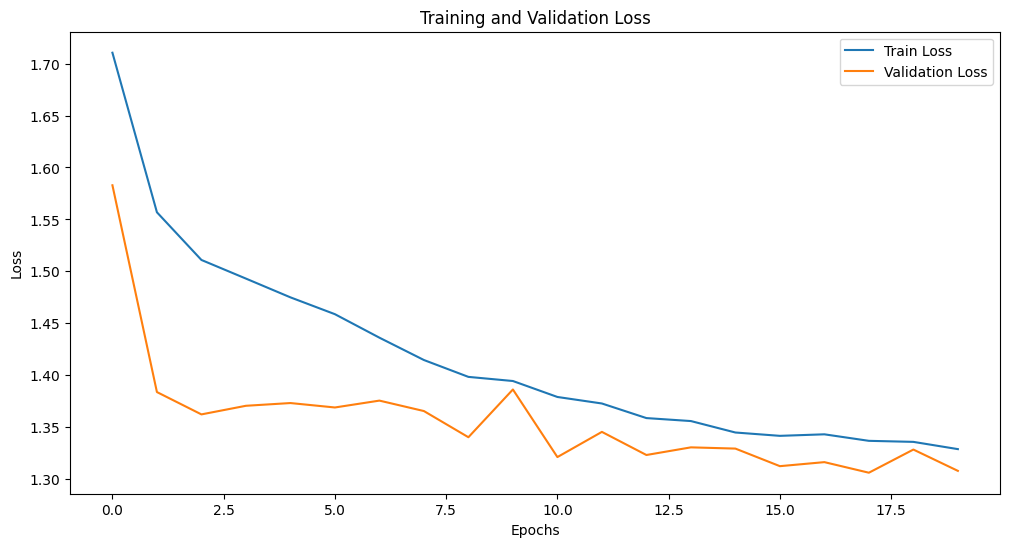

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, size_classes, morphology_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.size_output = nn.Linear(hidden_size2, size_classes)
        self.morphology_output = nn.Linear(hidden_size2, morphology_classes)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        size_output = self.size_output(out)
        morphology_output = self.morphology_output(out)
        return size_output, morphology_output


# Hyperparameters
input_size = X_train.shape[2]
time_steps = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
size_classes = y_size_train.shape[2]
morphology_classes = y_morphology_train.shape[2]
batch_size = 32
epochs = 20
learning_rate = 0.001

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_size_train_tensor = torch.tensor(y_size_train, dtype=torch.float32)
y_morphology_train_tensor = torch.tensor(y_morphology_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_size_test_tensor = torch.tensor(y_size_test, dtype=torch.float32)
y_morphology_test_tensor = torch.tensor(y_morphology_test, dtype=torch.float32)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_size_train_tensor, y_morphology_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_size_test_tensor, y_morphology_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss functions, and optimizer
model = LSTMModel(input_size, hidden_size1, hidden_size2, size_classes, morphology_classes)
criterion_size = nn.CrossEntropyLoss()
criterion_morphology = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_size_batch, y_morphology_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        size_logits, morphology_logits = model(X_batch)

        # Compute losses
        size_loss = criterion_size(size_logits.view(-1, size_classes), y_size_batch.view(-1, size_classes).argmax(dim=1))
        morphology_loss = criterion_morphology(morphology_logits.view(-1, morphology_classes), y_morphology_batch.view(-1, morphology_classes).argmax(dim=1))

        loss = size_loss + morphology_loss
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_size_batch, y_morphology_batch in test_loader:
            size_logits, morphology_logits = model(X_batch)
            size_loss = criterion_size(size_logits.view(-1, size_classes), y_size_batch.view(-1, size_classes).argmax(dim=1))
            morphology_loss = criterion_morphology(morphology_logits.view(-1, morphology_classes), y_morphology_batch.view(-1, morphology_classes).argmax(dim=1))
            val_loss += size_loss.item() + morphology_loss.item()

    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Save the model
torch.save(model.state_dict(), "/content/drive/My Drive/LSTM_Morphology_Size_Model.pth")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluation on test set
model.eval()  # Set the model to evaluation mode

all_size_preds = []
all_size_labels = []
all_morphology_preds = []
all_morphology_labels = []

with torch.no_grad():
    for X_batch, y_size_batch, y_morphology_batch in test_loader:
        size_logits, morphology_logits = model(X_batch)

        # Get predictions
        size_preds = torch.argmax(size_logits, dim=2).cpu().numpy().flatten()
        size_labels = torch.argmax(y_size_batch, dim=2).cpu().numpy().flatten()

        morphology_preds = torch.argmax(morphology_logits, dim=2).cpu().numpy().flatten()
        morphology_labels = torch.argmax(y_morphology_batch, dim=2).cpu().numpy().flatten()

        all_size_preds.extend(size_preds)
        all_size_labels.extend(size_labels)
        all_morphology_preds.extend(morphology_preds)
        all_morphology_labels.extend(morphology_labels)

# Compute evaluation metrics for size predictions
size_accuracy = accuracy_score(all_size_labels, all_size_preds)
size_precision = precision_score(all_size_labels, all_size_preds, average="weighted")
size_recall = recall_score(all_size_labels, all_size_preds, average="weighted")
size_f1 = f1_score(all_size_labels, all_size_preds, average="weighted")

print("Size Prediction Metrics:")
print(f"Accuracy: {size_accuracy:.4f}")
print(f"Precision: {size_precision:.4f}")
print(f"Recall: {size_recall:.4f}")
print(f"F1-Score: {size_f1:.4f}")

# Compute evaluation metrics for morphology predictions
morphology_accuracy = accuracy_score(all_morphology_labels, all_morphology_preds)
morphology_precision = precision_score(all_morphology_labels, all_morphology_preds, average="weighted")
morphology_recall = recall_score(all_morphology_labels, all_morphology_preds, average="weighted")
morphology_f1 = f1_score(all_morphology_labels, all_morphology_preds, average="weighted")

print("Morphology Prediction Metrics:")
print(f"Accuracy: {morphology_accuracy:.4f}")
print(f"Precision: {morphology_precision:.4f}")
print(f"Recall: {morphology_recall:.4f}")
print(f"F1-Score: {morphology_f1:.4f}")


Size Prediction Metrics:
Accuracy: 0.9432
Precision: 0.9278
Recall: 0.9432
F1-Score: 0.9328
Morphology Prediction Metrics:
Accuracy: 0.3274
Precision: 0.3373
Recall: 0.3274
F1-Score: 0.2886


In [ ]:
# Display sample predictions
def display_sample_predictions(loader, model, num_samples=3):
    model.eval()
    samples_displayed = 0

    with torch.no_grad():
        for X_batch, y_size_batch, y_morphology_batch in loader:
            size_logits, morphology_logits = model(X_batch)

            size_preds = torch.argmax(size_logits, dim=2).cpu().numpy()
            morphology_preds = torch.argmax(morphology_logits, dim=2).cpu().numpy()

            for i in range(X_batch.shape[0]):
                if samples_displayed >= num_samples:
                    return

                print(f"Sample {samples_displayed + 1}:")
                print(f"Predicted Size Class: {size_preds[i]}")
                print(f"True Size Class: {torch.argmax(y_size_batch[i], dim=1).cpu().numpy()}")
                print(f"Predicted Morphology Class: {morphology_preds[i]}")
                print(f"True Morphology Class: {torch.argmax(y_morphology_batch[i], dim=1).cpu().numpy()}")
                print("-" * 50)
                samples_displayed += 1

# Display predictions for 3 samples
display_sample_predictions(test_loader, model)


Sample 1:
Predicted Size Class: [0 0 0 0 0 0 0 0 0 0]
True Size Class: [0 0 0 0 0 0 0 0 0 0]
Predicted Morphology Class: [0 2 2 2 2 2 2 2 2 2]
True Morphology Class: [2 1 2 1 0 1 1 1 1 1]
--------------------------------------------------
Sample 2:
Predicted Size Class: [0 0 0 0 0 0 0 0 0 0]
True Size Class: [0 0 0 0 0 0 0 0 0 0]
Predicted Morphology Class: [2 2 2 2 2 2 2 2 2 2]
True Morphology Class: [2 1 2 0 1 2 2 2 0 1]
--------------------------------------------------
Sample 3:
Predicted Size Class: [0 0 0 0 0 0 0 0 0 0]
True Size Class: [0 0 0 0 0 0 0 0 0 0]
Predicted Morphology Class: [0 2 2 2 2 0 0 0 0 2]
True Morphology Class: [2 1 2 1 0 0 0 1 1 0]
--------------------------------------------------


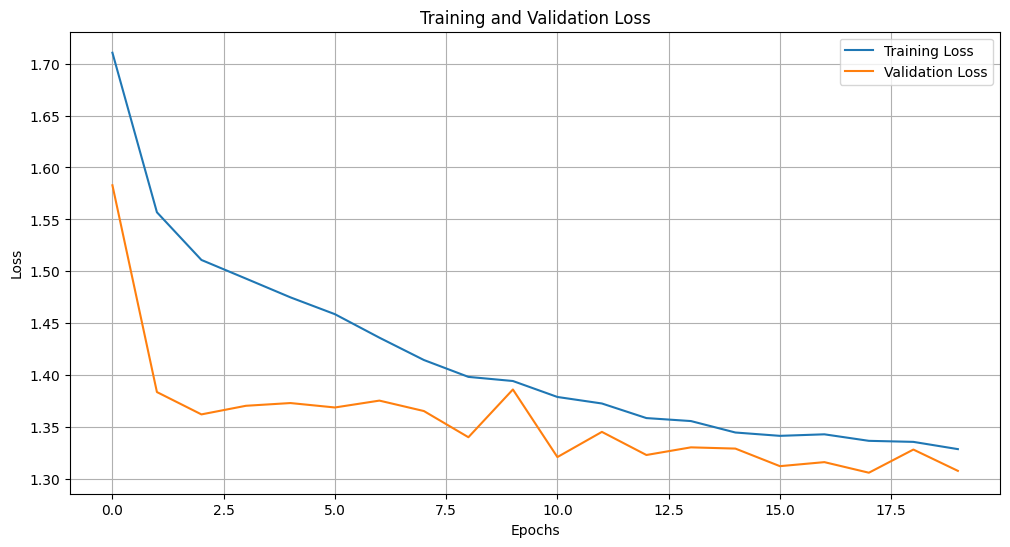

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


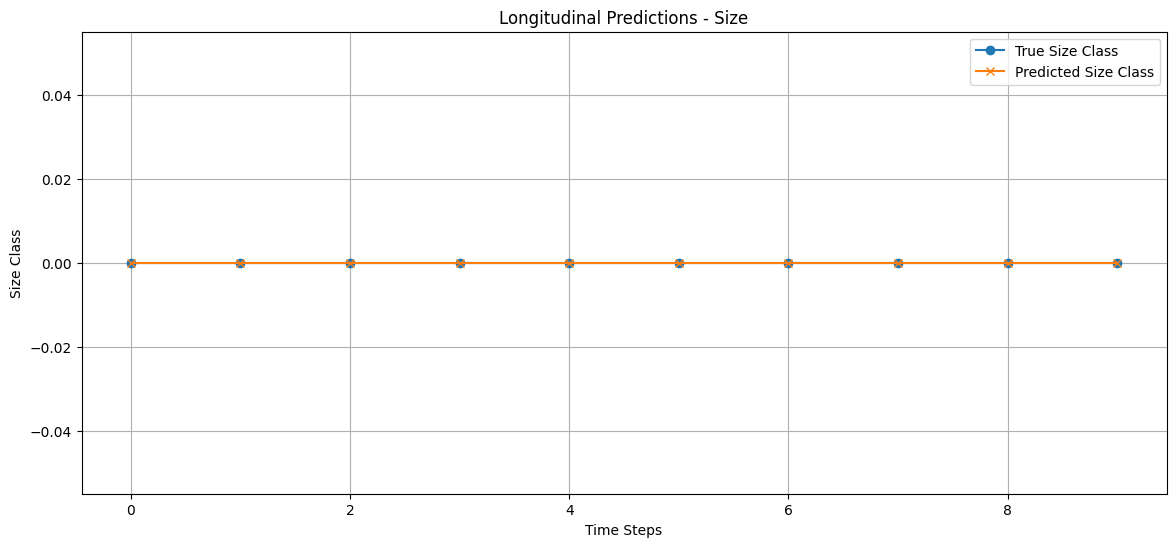

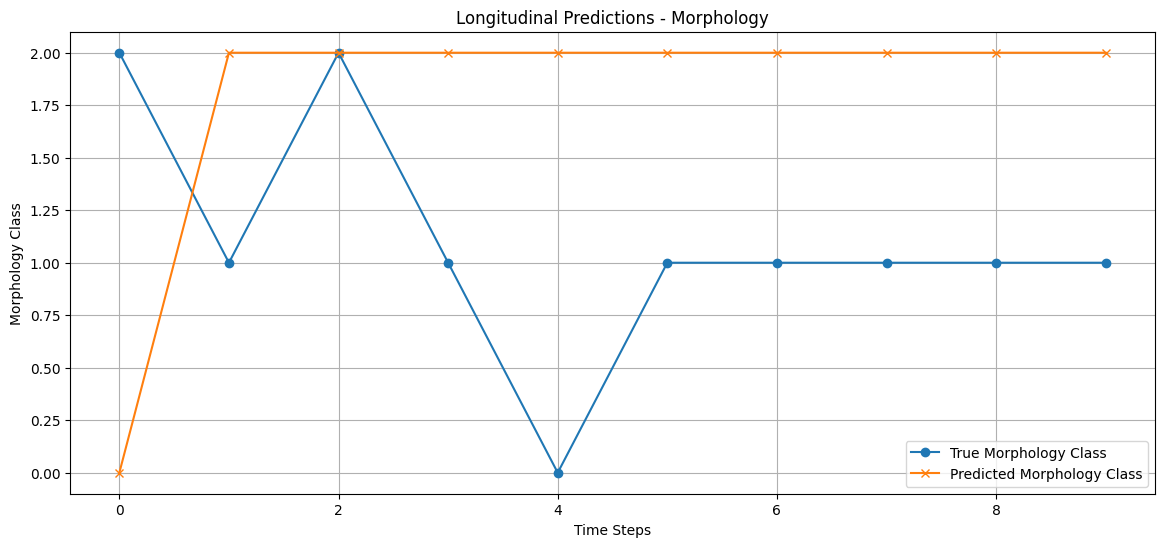

In [ ]:
def plot_longitudinal_predictions(loader, model, sample_index=0):
    model.eval()
    with torch.no_grad():
        for X_batch, y_size_batch, y_morphology_batch in loader:
            size_logits, morphology_logits = model(X_batch)

            # Select the sample
            true_size = torch.argmax(y_size_batch[sample_index], dim=1).cpu().numpy()
            pred_size = torch.argmax(size_logits[sample_index], dim=1).cpu().numpy()
            true_morphology = torch.argmax(y_morphology_batch[sample_index], dim=1).cpu().numpy()
            pred_morphology = torch.argmax(morphology_logits[sample_index], dim=1).cpu().numpy()

            # Plot size predictions
            plt.figure(figsize=(14, 6))
            plt.plot(true_size, label="True Size Class", marker="o")
            plt.plot(pred_size, label="Predicted Size Class", marker="x")
            plt.title("Longitudinal Predictions - Size")
            plt.xlabel("Time Steps")
            plt.ylabel("Size Class")
            plt.legend()
            plt.grid()
            plt.show()

            # Plot morphology predictions
            plt.figure(figsize=(14, 6))
            plt.plot(true_morphology, label="True Morphology Class", marker="o")
            plt.plot(pred_morphology, label="Predicted Morphology Class", marker="x")
            plt.title("Longitudinal Predictions - Morphology")
            plt.xlabel("Time Steps")
            plt.ylabel("Morphology Class")
            plt.legend()
            plt.grid()
            plt.show()

            break  # Display one sample only

# Visualize longitudinal predictions for the first sample
plot_longitudinal_predictions(test_loader, model, sample_index=0)


In [ ]:
def extract_longitudinal_predictions(loader, model):
    model.eval()
    longitudinal_data = []

    with torch.no_grad():
        for X_batch, _, _ in loader:
            size_logits, morphology_logits = model(X_batch)
            size_probs = torch.softmax(size_logits, dim=2).cpu().numpy()
            morphology_probs = torch.softmax(morphology_logits, dim=2).cpu().numpy()

            for i in range(X_batch.shape[0]):
                longitudinal_data.append({
                    "size_probs": size_probs[i],
                    "morphology_probs": morphology_probs[i],
                })

    print("Extracted Data Count:", len(longitudinal_data))  # Debugging
    return longitudinal_data


In [ ]:
def analyze_evolution(longitudinal_data, time_steps, size_classes, morphology_classes):
    if not longitudinal_data:
        print("No data found in longitudinal predictions.")
        return

    for idx, sample in enumerate(longitudinal_data[:3]):  # Analyze first 3 samples
        print(f"Sample {idx + 1}:")

        size_probs = sample["size_probs"]
        predicted_sizes = np.argmax(size_probs, axis=1)
        print("Size Predictions Over Time:")
        for t in range(time_steps):
            print(f"Time Step {t + 1}: Class = {size_classes[predicted_sizes[t]]}, Probabilities = {size_probs[t]}")

        morphology_probs = sample["morphology_probs"]
        predicted_morphologies = np.argmax(morphology_probs, axis=1)
        print("\nMorphology Predictions Over Time:")
        for t in range(time_steps):
            print(f"Time Step {t + 1}: Class = {morphology_classes[predicted_morphologies[t]]}, Probabilities = {morphology_probs[t]}")

        print("-" * 50)


In [ ]:
def plot_evolution_over_time(longitudinal_data, time_steps, size_classes, morphology_classes):
    if not longitudinal_data:
        print("No data available for plotting.")
        return

    for idx, sample in enumerate(longitudinal_data[:1]):  # Plot first sample
        size_probs = sample["size_probs"]
        morphology_probs = sample["morphology_probs"]

        # Plot size probabilities
        plt.figure(figsize=(14, 6))
        for i, size_class in enumerate(size_classes):
            plt.plot(range(1, time_steps + 1), size_probs[:, i], label=f"Size - {size_class}")
        plt.title("Size Class Probabilities Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("Probability")
        plt.legend()
        plt.grid()
        plt.show()

        # Plot morphology probabilities
        plt.figure(figsize=(14, 6))
        for i, morphology_class in enumerate(morphology_classes):
            plt.plot(range(1, time_steps + 1), morphology_probs[:, i], label=f"Morphology - {morphology_class}")
        plt.title("Morphology Class Probabilities Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("Probability")
        plt.legend()
        plt.grid()
        plt.show()
